In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd

# za normalizaciju
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# rad sa arff fajlovima
#import arff

# grafici
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# importujemo neighbors modul
#from sklearn import neighbors

# 
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Cross validation attempts to avoid overfitting while still 
# producing a prediction for each observation dataset.
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# Compute precision, recall, F-measure and support

# prognozirani pozitivni/negativni koji su zaista pozitivni od svih prognoziranih pozitivnih/negativnih 
# The precision is the ratio tp / (tp + fp) where tp is the number 
# of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier 
# to not label a sample as positive if it is negative

# odziv?
# => prognozirani pozitivni/negativni koji su zaista pozitivni od ukupno pozitivnih/negativnih
# The recall is the ratio tp / (tp + fn) where tp is the number 
# of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0

# The F-beta score weights the recall more than the precision by a factor of beta. 
# beta = 1.0 means recall and precision are equally important

# svi koji pripadaju datoj klasi
# The support is the number of occurrences of each class in y_test

from sklearn.metrics import classification_report

# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# oversampling
from imblearn.over_sampling import SMOTE

from collections import Counter

# feature selection
#from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.ensemble import ExtraTreesClassifier

In [2]:
from arff2pandas import a2p
    
with open('JM1.arff') as f:
    df = a2p.load(f)

print(df.shape)

(10878, 22)


In [3]:
# uklanjamo instance koje imaju nedostajuce vrednosti
df = df.dropna()
print(df.shape)

(10878, 22)


In [4]:
df = df.drop(columns = ['CYCLOMATIC_COMPLEXITY@NUMERIC', 'DESIGN_COMPLEXITY@NUMERIC', 'ESSENTIAL_COMPLEXITY@NUMERIC', 'BRANCH_COUNT@NUMERIC'])

In [5]:
df['Defective@{Y,N}'].value_counts()

N    8776
Y    2102
Name: Defective@{Y,N}, dtype: int64

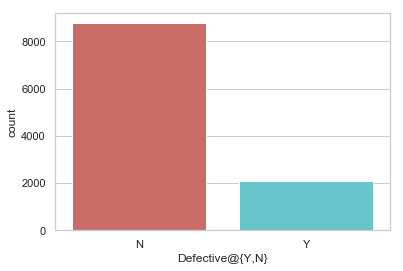

In [6]:
sns.countplot(x='Defective@{Y,N}', data=df, palette='hls')
plt.show()

In [7]:
# kodiramo Y/N u 1/0
df['Defective@{Y,N}'] = pd.factorize(df['Defective@{Y,N}'])[0]

In [8]:
# ciljna kolona(defects@{false, true})
y_cols=['Defective@{Y,N}']

# lista atributa
X_cols=[i for i in df.columns if i not in y_cols]

In [9]:
X=df[X_cols]
y=df[y_cols]

In [10]:
np.set_printoptions(suppress='True')

In [11]:
# X = preprocessing.normalize(X)

X = preprocessing.scale(X)

In [12]:
y = y.values.ravel()

In [13]:
# Grafik rasporedjenosti instanci po klasama pokazuje da postoji problem neravnomerne raspodele klasa instanci
# Posledica ove neravnomerne raspodele je da ce trenirani model dobro klasifikovati instance klase 'N', a lose
# klasifikovati instance cija je klasa 'Y'. Medjutim, problem je u tome sto su instance od znacaja bas instance klase 'Y'
# Resenje ovog problema je over-sampling - dodavanje novih instanci koje pripadaju manje zastupljenoj klasi 'Y'
# Postoji vise metoda dodavanja novih instanci, a probacemo SMOTE

# Prvo, radimo izbor atributa 
# Da li se isplati raditi

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [15]:
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=150)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8102022058823529


In [16]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X, np.ravel(y), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.797234783
standard deviation: 0.301721381


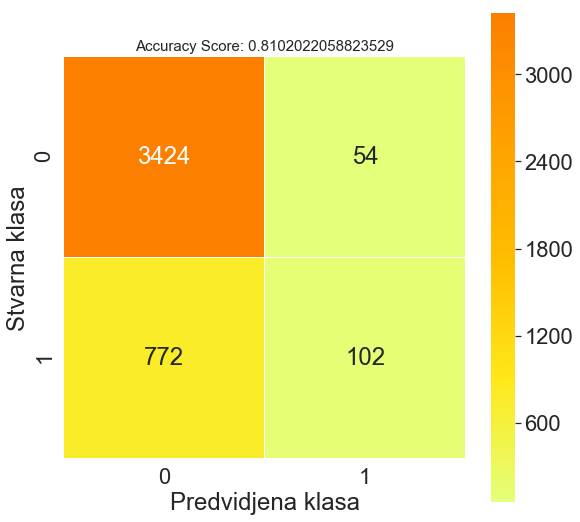

In [17]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Wistia');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'LR_basic_data_confussion_matrix.png'
plt.savefig(figname)
plt.show()

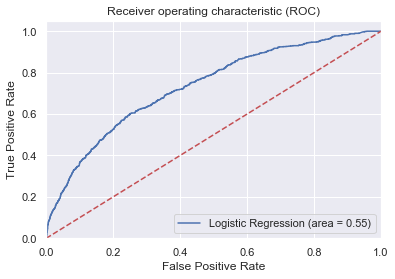

In [18]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'LR_basic_data_ROC.png'
plt.savefig(figname)
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3478
           1       0.65      0.12      0.20       874

   micro avg       0.81      0.81      0.81      4352
   macro avg       0.73      0.55      0.55      4352
weighted avg       0.78      0.81      0.75      4352



In [20]:
# oversampling

In [21]:
X_resampled, y_resampled = SMOTE(kind="svm").fit_sample(X, y)

In [22]:
print(sorted(Counter(y_resampled).items()))

[(0, 8776), (1, 8776)]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [24]:
clf = LogisticRegression(random_state=0, max_iter=150, solver='lbfgs')
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7151402934054978


In [25]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_resampled, np.ravel(y_resampled), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.649678692
standard deviation: 0.133065863


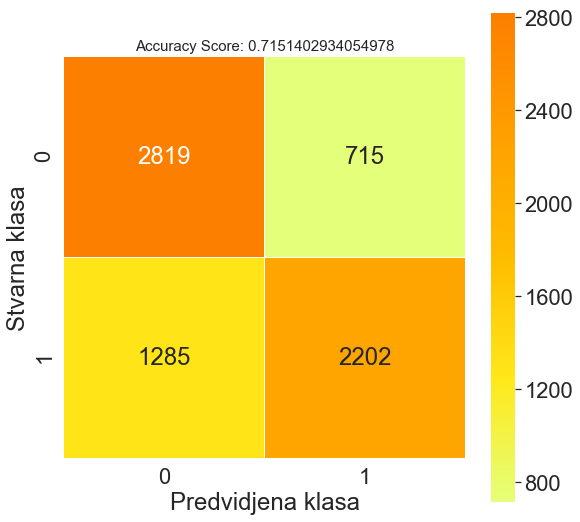

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Wistia');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'LR_oversampled_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      3534
           1       0.75      0.63      0.69      3487

   micro avg       0.72      0.72      0.72      7021
   macro avg       0.72      0.71      0.71      7021
weighted avg       0.72      0.72      0.71      7021



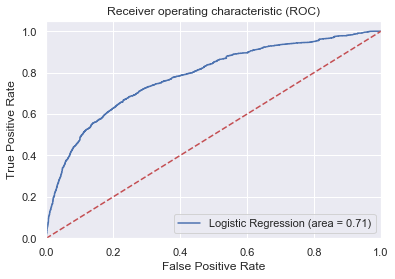

In [28]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'LR_oversampled_ROC.png'
plt.savefig(figname)
plt.show()

In [29]:
# izbor atributa, originalni podaci

In [30]:
X_indices = np.arange(X.shape[-1])

In [31]:
# selector = SelectPercentile(f_classif, percentile=60)
# selector.fit(X, y)

selector = ExtraTreesClassifier(n_estimators=100)
selector.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
print(selector.feature_importances_)

[0.06806382 0.03155487 0.0474961  0.06528744 0.05965781 0.05448763
 0.05240804 0.04488963 0.05794607 0.04621934 0.05162328 0.05690978
 0.06064903 0.0610236  0.05929016 0.05925694 0.12323646]


In [33]:
#X_transformed = selector.transform(X)

In [34]:
feature_importances = selector.feature_importances_

In [35]:
#scores = -np.log10(selector.pvalues_)
#scores /= scores.max()

<BarContainer object of 17 artists>

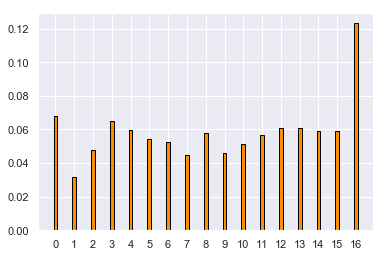

In [36]:
sns.set(font_scale=1)
plt.xticks(np.arange(0, len(X_indices)+1, 1.0))
plt.bar(X_indices , selector.feature_importances_, width=.2, label=r'ExtraTreesClasifier', color='darkorange',
        edgecolor='black')

In [37]:
# ind = np.argpartition(scores, -10)[-10:]
ind = np.argpartition(feature_importances, -10)[-10:]

In [38]:
df.columns[ind]

Index(['HALSTEAD_VOLUME@NUMERIC', 'HALSTEAD_LENGTH@NUMERIC',
       'NUM_UNIQUE_OPERATORS@NUMERIC', 'HALSTEAD_CONTENT@NUMERIC',
       'LOC_EXECUTABLE@NUMERIC', 'NUM_OPERANDS@NUMERIC',
       'NUM_OPERATORS@NUMERIC', 'NUM_UNIQUE_OPERANDS@NUMERIC',
       'LOC_BLANK@NUMERIC', 'LOC_TOTAL@NUMERIC'],
      dtype='object')

In [39]:
to_remove = [a for a in X_indices if a not in ind] 

In [40]:
X_transformed = np.delete(X, to_remove, axis=1)

In [41]:
# posle izbora atributa i oversampling-a 

In [42]:
X_resampled, y_resampled = SMOTE().fit_sample(X_transformed, y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [44]:
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=150)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6564591938470303


In [45]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_resampled, np.ravel(y_resampled), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.564495616
standard deviation: 0.093246520


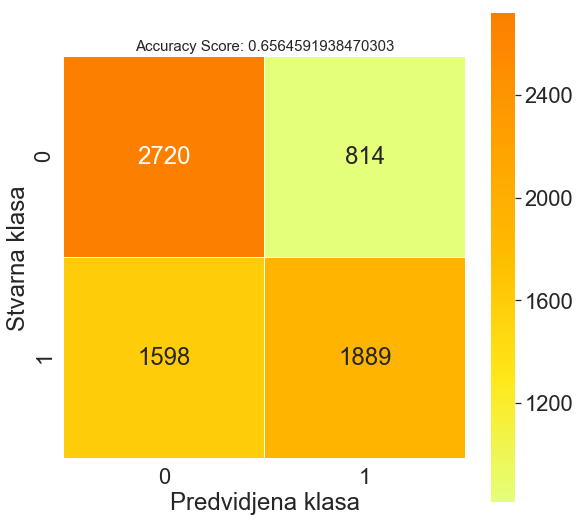

In [46]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Wistia');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'LR_feature_selection_oversampling_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      3534
           1       0.70      0.54      0.61      3487

   micro avg       0.66      0.66      0.66      7021
   macro avg       0.66      0.66      0.65      7021
weighted avg       0.66      0.66      0.65      7021



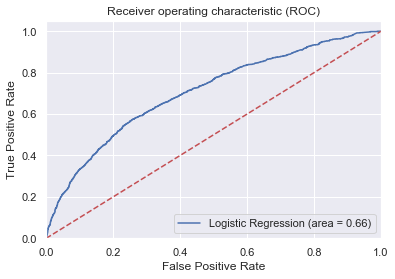

In [48]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'LR_feature_selection_oversampling_ROC.png'
plt.savefig(figname)
plt.show()